In [1]:
%config InlineBackend.figure_format = "retina"

In [2]:
import pandas as pd
import numpy as np
import pickle

from model import NeuralNetwork     #, NeuralNetwork_Adjustable
from utils import count_parameters, plot_metrics

import torch
#torch.autograd.detect_anomaly(True)

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics.classification import BinaryAccuracy, AUROC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics

from time import time

import gc, os

In [3]:

################################################################ device settings ################################################################
dtype  = 'np.float32'
device = "mps" if torch.backends.mps.is_available() else "cpu"     
device = torch.device(device)
print(f"Using device: {device}")
################################################################ Data Preparation ################################################################
sample_size  = int(1e+6)
print('Preparing data...')
start = time()
       
df  = pd.read_hdf(f'/Users/asugu/Desktop/b_tag_DNN/data/all_data_{sample_size}.hdf5', key='data', dtype=dtype)   
df = df.astype(np.float32)   

Using device: mps
Preparing data...


In [4]:
df['pt_cosh']=df['jet_pt']*np.cosh(df['jet_eta'])     # |p|

In [5]:
col_names = df.keys()
target_col_name = "jet_flavor"
input_col_names = [col_name for col_name in col_names if col_name != target_col_name]
df.replace({"inf": 0, "-inf": 0}, inplace=True)


df = df[(np.abs(df-df.mean()) <= 10*df.std()).all(axis=1)]


inputs = df[input_col_names]
labels = df[target_col_name] 
labels = (labels==5).astype(int) #np.array([1 if i == 5 else 0 for i in labels]) 

del df
gc.collect()

47

In [6]:
train_inputs, val_inputs, train_labels, val_labels = train_test_split(inputs, labels, stratify = labels, test_size = 0.2, shuffle = True, random_state = 42)

del inputs, labels
gc.collect()


scaler = StandardScaler()
train_inputs = scaler.fit_transform(train_inputs)
val_inputs  = scaler.transform(val_inputs)

pca_decomposition = PCA()
train_inputs = pca_decomposition.fit_transform(train_inputs)
val_inputs   = pca_decomposition.transform(val_inputs)

train_inputs = torch.tensor(train_inputs,  dtype=torch.float32, device = 'cpu')
train_labels = torch.tensor(train_labels.to_numpy(),  dtype=torch.float32, device = 'cpu').reshape(-1, 1)

val_inputs  = torch.tensor(val_inputs,  dtype=torch.float32, device = device)
val_labels  = torch.tensor(val_labels.to_numpy(),  dtype=torch.float32, device = device).reshape(-1, 1)

batchsize   = int(len(train_inputs)/10)
trainloader = DataLoader(list(zip(train_inputs, train_labels)), batch_size = batchsize , drop_last=True )

finish = time()

print(f'Data preparation has taken {finish-start:.1f} seconds for {len(train_inputs)+len(val_inputs)} rows.')
      



Data preparation has taken 67.5 seconds for 930889 rows.
+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  layer1.weight  |   13984    |
|   layer1.bias   |     32     |
|  layer2.weight  |    1024    |
|   layer2.bias   |     32     |
|  layer3.weight  |    1024    |
|   layer3.bias   |     32     |
|  layer4.weight  |    1024    |
|   layer4.bias   |     32     |
|  layer5.weight  |    1024    |
|   layer5.bias   |     32     |
|  layer6.weight  |    1024    |
|   layer6.bias   |     32     |
| layerfin.weight |     32     |
|  layerfin.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 19329


In [9]:
######################################################### Model constrcution #########################################################

print('Building model...', end='\r')
input_size  = len(input_col_names)
output_size = 1
model = NeuralNetwork(input_size, output_size, nnode=32)
#model = NeuralNetwork_Adjustable(input_size, output_size, n_hidden_layers = 1, nnodes=4)
count_parameters(model)

##################################################### Loss and Optimizer Settings #####################################################

def learning_rate(i_epoch, initial_lr = 0.01, decay_rate = 0.01):
    return initial_lr * (1-decay_rate)**i_epoch

criterion = nn.BCELoss()       
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.01, weight_decay=1e-4)

+-----------------+------------+
|     Modules     | Parameters |
+-----------------+------------+
|  layer1.weight  |   13984    |
|   layer1.bias   |     32     |
|  layer2.weight  |    1024    |
|   layer2.bias   |     32     |
|  layer3.weight  |    1024    |
|   layer3.bias   |     32     |
|  layer4.weight  |    1024    |
|   layer4.bias   |     32     |
|  layer5.weight  |    1024    |
|   layer5.bias   |     32     |
|  layer6.weight  |    1024    |
|   layer6.bias   |     32     |
| layerfin.weight |     32     |
|  layerfin.bias  |     1      |
+-----------------+------------+
Total Trainable Params: 19329


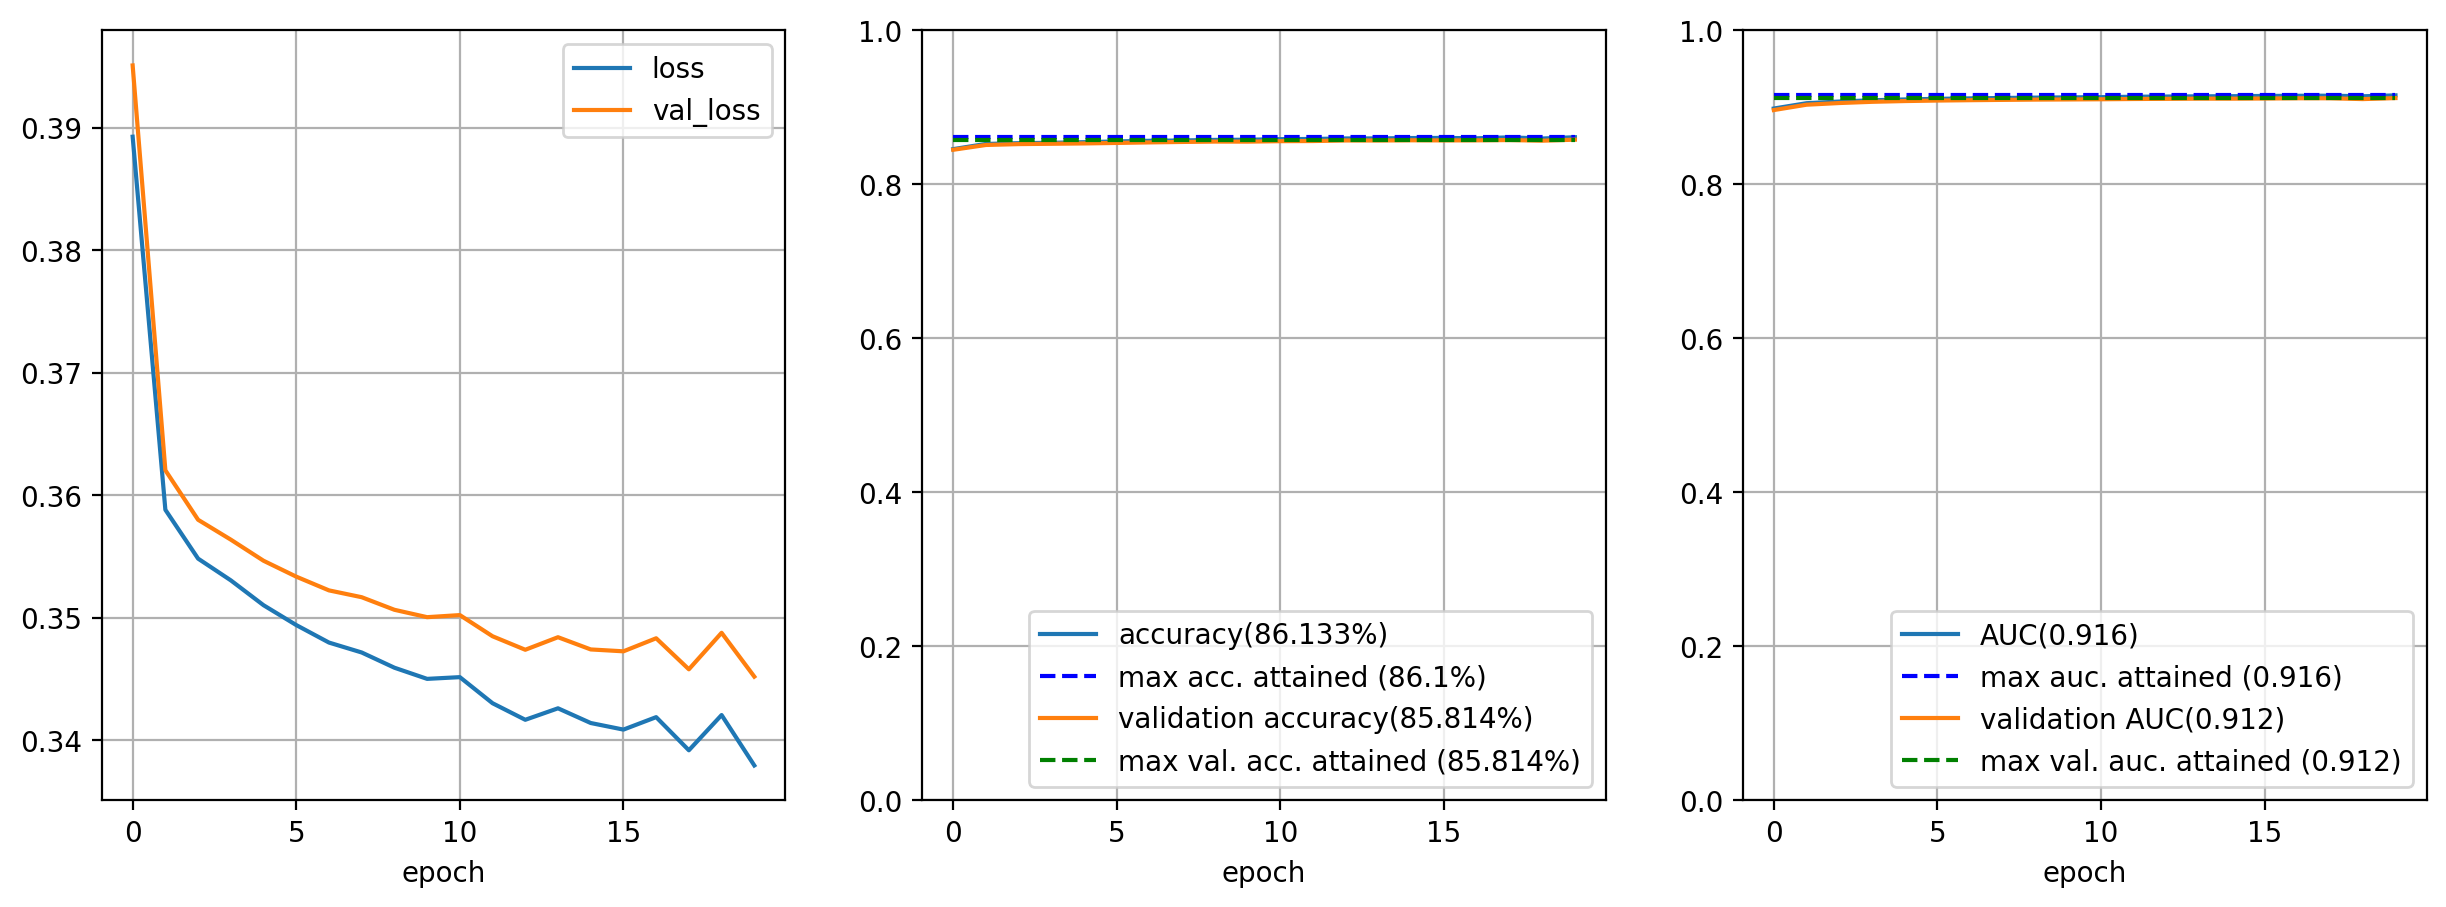

Training: Epoch [20/20] --- Loss: 0.3380 --- Accuracy: 0.8613 --- AUC: 0.916
Test    : Epoch [20/20] --- Loss: 0.3452 --- Accuracy: 0.8581 --- AUC: 0.912


In [10]:
############################################################# Training #############################################################

n_epochs  = 20

train_losses = []
train_accuracies = []
train_aucs = []
val_losses = []
val_accuracies = []
val_aucs = []

for i_epoch in range(n_epochs):
    
    ## Decay the learning rate by increasing epcoh number
    optimizer.param_groups[0]['lr'] = learning_rate(i_epoch, initial_lr=0.005, decay_rate=0.01)  # can i change lr here without changing it in torch.optim. line
    lr = optimizer.param_groups[0]['lr']
    print(f'learning rate was set to {lr:.5f}.')
    
    train_loop = trainloader     
    
    ############################################################ Batch Training ############################################################
    model.to(device)   # this should be out of the loop
    model.train() # also this
    for i_batch, (train_input, train_label) in enumerate(train_loop):
        
        train_input = train_input.float().to(device)
        train_label = train_label.reshape(-1,1).float().to(device)
            
        optimizer.zero_grad()
        
        train_pred = model(train_input)
        #train_pred[train_pred!=train_pred] = 0
        
        loss = criterion(train_pred, train_label)
        
        if not torch.isnan(loss): # safety
            loss.backward()
            optimizer.step()
        
    #########################################################  Evaluate metrics #########################################################
    
    print('Evaluating metrics...', end='\r')
    
    acc_metric = BinaryAccuracy()
    auc_metric = AUROC(task="binary")
    
    model.eval()
        
    with torch.no_grad():
        
        model.to('cpu')
        val_inputs = val_inputs.cpu()
        val_labels = val_labels.cpu()
        
        train_preds = model(train_inputs)
        #train_preds[train_preds!=train_preds] = 0
        
        val_preds  = model(val_inputs)
        #val_preds[val_preds!=val_preds] = 0
        
        train_loss = criterion(train_preds, train_labels)
        val_loss  = criterion(val_preds, val_labels)
        
        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())
        
        train_accuracy = acc_metric(train_preds, train_labels)
        val_accuracy = acc_metric(val_preds, val_labels)
        
        train_accuracies.append(train_accuracy.item())
        val_accuracies.append(val_accuracy.item())
        
        train_auc = auc_metric(train_preds, train_labels)
        val_auc = auc_metric(val_preds, val_labels)
        
        train_aucs.append(train_auc.item())
        val_aucs.append(val_auc.item())
    
    plot_metrics(np.arange(i_epoch+1), train_losses, val_losses, train_accuracies, val_accuracies, train_aucs, val_aucs)
        
     
    print('Evaluating metrics finished!', end='\r')  
    print(f'Training: Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {train_losses[-1]:.4f} --- Accuracy: {train_accuracies[-1]:.4f} --- AUC: {train_aucs[-1]:.3f}\nTest    : Epoch [{i_epoch+1}/{n_epochs}] --- Loss: {val_losses[-1]:.4f} --- Accuracy: {val_accuracies[-1]:.4f} --- AUC: {val_aucs[-1]:.3f}\n', end='\r')


# put all metrics to dictionary and save it for further analysis
keys         = ['train_losses','train_accuracies','train_aucs','val_losses','val_accuracies', 'val_aucs']
values       = [train_losses , train_accuracies , train_aucs , val_losses , val_accuracies , val_aucs]
dict_metrics = {keys[i]: values[i] for i in range(len(keys))}

with open('history_dict.pickle', 'wb') as file:
    pickle.dump(dict_metrics, file)